# Implementation of U-Net Architecture

**The U-Net Architucture was introduced on the paper entitled [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597) by Olaf Ronneberger.**

This project is an implementation of the aferomentioned architecture. The dataset used in this model is from the [ISBI Challenge](http://brainiac2.mit.edu/isbi_challenge/).

**Import the needed libraries**

In [62]:
import os, shutil
import numpy as np 
import matplotlib.pyplot as plt

import skimage.io as io
import skimage.transform as trans

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, concatenate, Dropout, Input, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import load_model

**Defining the paths where the data is located**

In [63]:
data_dir = 'data'
train_data_dir = 'data/train'
train_images_dir = 'data/train/images'
train_masks_dir = 'data/train/masks'
test_data_dir = 'data/test'

**Data Preprocessing**

Because the dataset used is fairly small, data augmentation will be needed for a better performance.

In [64]:
data_gen_args = dict(rescale=1./255,
                     rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

We can visualise the resulting images of the data augmentation using the data generator, and tune the parameters if needed. 

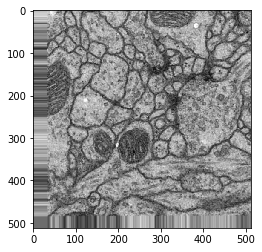

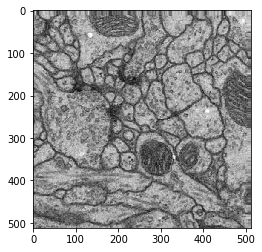

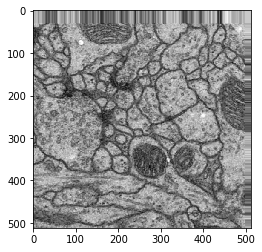

In [65]:
fnames = [os.path.join(train_images_dir, fname) for fname in os.listdir(train_images_dir)]

img_path = fnames[2]
loaded_img = image.load_img(img_path, target_size=(512, 512))

img = image.img_to_array(loaded_img)
img = img.reshape((1,) + img.shape)

i = 0
for batch in image_datagen.flow(img, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
        
plt.show()

Define the generators for the train and test data. The train generator includes both the images and the respective masks to feed the model together. Important to set the same seed for images and masks generators.
Couldn't use the ImageDataGenerator for the test dataset due to the fact that the test images won't be processed in order, making it harder to compare the inputs and outputs. For that reason another generator is defined for the test dataset.

In [70]:
def trainGenerator():
    train_image_generator = image_datagen.flow_from_directory(
        train_data_dir,
        classes = ['images'],
        class_mode = None,
        color_mode = 'grayscale',
        target_size = (256, 256),
        batch_size = 2,
        save_to_dir = 'data/train/aug',
        save_prefix = 'image',
        seed = 1)
    
    train_mask_generator = image_datagen.flow_from_directory(
        train_data_dir,
        classes = ['masks'],
        class_mode = None,
        color_mode = 'grayscale',
        target_size = (256, 256),
        batch_size = 2,
        save_to_dir = 'data/train/aug',
        save_prefix = 'mask',
        seed = 1) 
    
    train_generator = zip(train_image_generator, train_mask_generator)
    
    return train_generator


def testGenerator():
    for i in range(30):
        image = io.imread(os.path.join(test_data_dir,"%d.png"%i),as_gray = True)
        image = image / 255
        image = trans.resize(image, (256,256), mode='constant')
        image = np.reshape(image, image.shape+(1,))
        image = np.reshape(image, (1,)+image.shape)
        yield image

**Defining the Model**

Building the model according to the papers architecture. 

The kernel initalizer used is **'he_normal'**. This initialzier draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / fan_in) where fan_in is the number of input units in the weight tensor.

**'Adam'** is the chosen optimizer to be used.

In [67]:
inputs = Input((256,256,1))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
concat6 = concatenate([drop4,up6])
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(concat6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
concat7 = concatenate([conv3,up7])
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(concat7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
concat8 = concatenate([conv2,up8])
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(concat8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
concat9 = concatenate([conv1,up9])
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(concat9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(inputs = inputs, outputs = conv10)

model.compile(optimizer=Adam(lr = 1e-4), loss='binary_crossentropy', metrics = ['accuracy'])
    
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 256, 256, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_73[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 128, 128, 64) 0           conv2d_74[0][0]                  
__________________________________________________________________________________________________
conv2d_75 

Finally let's train the model with the generated data from the previously defined generators.

In [13]:
train_generator = trainGenerator()

history = model.fit_generator(train_generator, steps_per_epoch=50, epochs=5)

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/5
100/100 [==============================] - 663s 7s/step - loss: 0.3686 - acc: 0.7424
Epoch 2/5
100/100 [==============================] - 718s 7s/step - loss: 0.3265 - acc: 0.7680
Epoch 3/5
100/100 [==============================] - 683s 7s/step - loss: 0.3079 - acc: 0.7821
Epoch 4/5
100/100 [==============================] - 667s 7s/step - loss: 0.2928 - acc: 0.7926
Epoch 5/5
100/100 [==============================] - 688s 7s/step - loss: 0.2856 - acc: 0.7966


In [14]:
model.save('U-NET (100 steps & 5 epochs).h5')

In [68]:
#model = load_model('U-NET (100 steps & 5 epochs).h5')

**Plotting the loss and accuracy of the predictions made by the implemented model**

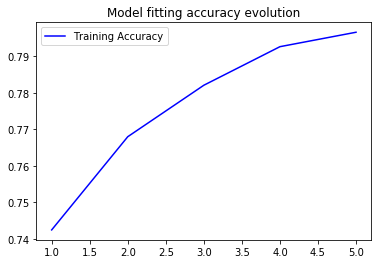

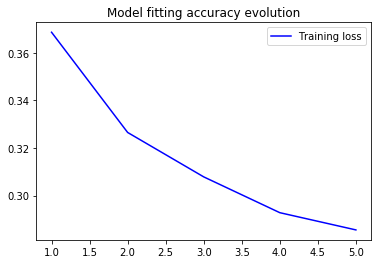

In [15]:
acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.title('Model fitting accuracy evolution')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Model fitting accuracy evolution')
plt.legend()

plt.show()

**Make predictions with the test dataset**

The last step is to use the implemented model to make predictions with the test data set. Ultimately save the prediction images so we can check how the model behaved, and how accurate are the predictions.

In [71]:
test_generator = testGenerator()

results = model.predict_generator(test_generator, 30, verbose = 1)

for index, result in enumerate(results):
    img = result[:,:,0]
    io.imsave(os.path.join(test_data_dir,"%d_predict.png" % index), img)

30/30 [==============================] - 30s 1s/step


/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


We can now visualize one of the input test images and its corresponding output.

**Original Image**

![Original Image](data/test/0.png)

**Predicted Image Segmentation**

![Predicted Image Segmentation](data/test/0_predict.png)